# Findings from the corpus analysis

My thesis involves analysing the lexicogrammatical features of a linguitic change in an online support
group for bipolar disorder. These features are then linked to discourse and
semantics via systemic functional linguistic theory. To do this, I rely on
corpus/computational linguistic techniques. A lot of the work is done by a
purpose-built Python module, *corpkit*.

This Notebook is the second of three. It contains an analysis of MOOD features
in the forum. To do this, I rely on constituency
grammar and [Tregex](http://nlp.stanford.edu/manning/courses/ling289/Tregex.html) to search the parse trees. As per systemic-functional theory, MOOD features are related to the ways
in which language is used to negotiate interpersonal relationships. This connection is discussed in the thesis,
but not here.

This Notebook contains the code used to generate key tables and figures in the
thesis, as well as a few extra details here and there. If you have the dataset,
it can be used to reproduce or modify findings. You could also use the code to
investigate your own data.

<!-- MarkdownTOC -->

- [Getting started](#getting-started)
- [Loading data from file](#loading-data-from-file)
- [Counting shallow features](#counting-shallow-features)
- [Mood features](#mood-features)
- [Modalisation](#modalisation)
- [Advice](#advice)
<!-- /MarkdownTOC -->

<a name="getting-started"></a>
## Getting started

Before we start doing anything substantial, we need to set some display options,
and import some modules:

In [1]:
# table viewing parameters
import pandas as pd
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', None)
pd.set_option('display.precision', 2)
pd.set_option('expand_frame_repr', True)

# display html table
from IPython.display import display, HTML

# move to correct directory
import os
os.chdir('/Users/daniel/work/new_thesis/')

# allow interactive inline images
%matplotlib inline

# a colormap with edges cut off
import matplotlib.pyplot as plt
import seaborn as sns

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """remove extreme values from colourmap"""
    import matplotlib.colors as colors
    import numpy as np
    new_cmap = colors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
    cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = truncate_colormap(plt.get_cmap('viridis'), 0.2, 0.7)

With this done, we are ready to import *corpkit*, and create an object
representing our four corpora, which have already been parsed:

In [2]:
# corpus and interrogation classes
from corpkit import *
# wordlists
from dictionaries import *
#corpus = Corpus('P-parsed', load_saved=True)
corpus = Corpus('P-parsed')

Corpus: /Users/daniel/Work/new_thesis/data/P-parsed


<a name="loading-data-from-file"></a>
## Loading data from file

Investigations take a long time to run. This cell maps saved data to the local
namespace. It's only useful if you have saved the interrogations.

Interrogations can take hours on a small machine. Therefore, after an interrogation
has been run, it is saved, and loaded as a corpus attribute in the cell above.

To save some time, we can map some loaded interrogations to the local namespace. If you're 
running this notebook locally, and haven't got the saved data, you don't need to run the
following cell.

In [12]:
sents = corpus.sents_with_verb
modals_w = corpus.modals_w
modals_l = corpus.modals_l
modal_configs = corpus.modal_configs
pronountense = corpus.pronoun_tense
tense = corpus.tense
negation = corpus.polarity
mp = corpus.mod_pol
sp = corpus.subj_pol

Within the `corpora` object, each corpus can be accessed as an attribute:

Each corpus has subcorpora, as well as files:

In [6]:
list(corpus.subcorpora)

[<corpkit.corpus.Subcorpus instance: dropout>,
 <corpkit.corpus.Subcorpus instance: future-veteran>]

In [7]:
corpus.subcorpora[0].files[78]

<corpkit.corpus.File instance: user-*PrincessRulerOfTheWorld*-2.txt.xml>

Using CoreNLP XML, it is possible to get lexicogramatical feature of any file
directly:

In [8]:
corpus.subcorpora[0].files[78].document.sentences[0].parse_string

'(ROOT (S (NP (PRP I)) (VP (VBP HATE) (NP (NNS THIS))) (. !))) '

There are specific functions for counting and tabulating these features,
however, which we will use instead.

<a name="mood-features"></a>
## Mood features

In this section, we'll look at Mood and modality choices in the main corpus.

From the features attribute, we can access a few different mood types:

In [3]:
# make list of mood types
moods = ['Unmodalised declarative', 
         'Modalised declarative',  
         'Interrogative',
         'Imperative']

We also want to get a count of sentences containing a verb:

In [ ]:
# get all verbs as regex
verbreg = verbs.words.as_regex('l')
# get non-clause sentences
minc = corpus.interrogate(T, r'ROOT !<< (VP !< VP <<# /%s/)' % verbreg, show=C)
# subtract from Sentence count
sents = corpus.features.Sentences - minc.results

Now, we get the mood count data from the `features`, calculate the number of
unknown mood types, and do some plotting:

In [4]:
# get just the moods
sents = load('P-parsed-sents_with_verb')
moodcounts = corpus.features[moods].copy()

In [5]:
# add the number of unknown mood as column
sents.index=range(1,11)
moodcounts['Unknown'] = corpus.features.Sentences - moodcounts.sum(axis=1)
moodcounts

,Unmodalised declarative,Modalised declarative,Interrogative,Imperative,Unknown
01,35697,3705,4999,517,21501
02,25817,3107,3400,481,16717
03,21353,2845,2813,413,13566
04,26900,3732,3711,554,17104
05,26014,3626,3522,558,16414
06,25035,3895,3653,605,16768
07,24042,3640,3351,532,16263
08,25061,3939,3496,621,16958
09,21536,3840,3146,599,15334
10,20690,4336,3181,456,11971


/Users/daniel/virtenvs/ssled/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


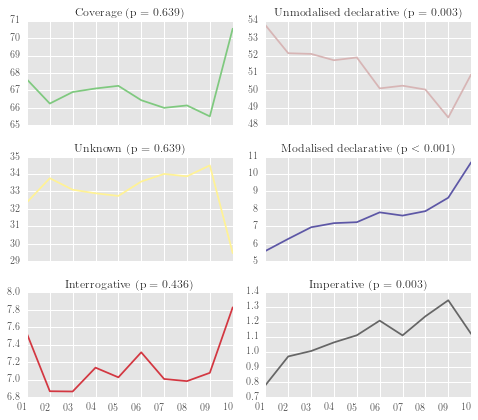

In [6]:
# get relative frequency
relmoodcounts = moodcounts.edit('%', SELF)
relmoodcounts.results['Coverage'] = moodcounts[moods].sum(axis=1) * 100.0 / moodcounts.sum(axis=1) 
relmoodcounts = relmoodcounts.edit(sort_by='total', keep_stats=True)
relmoodcounts
# visualise
relmoodcounts.visualise('Mood and Indicative Types in P Corpus', num_to_plot=8, show_p_val=True,
    subplots=True, layout=(3, 2), figsize=(7, 6)).show()

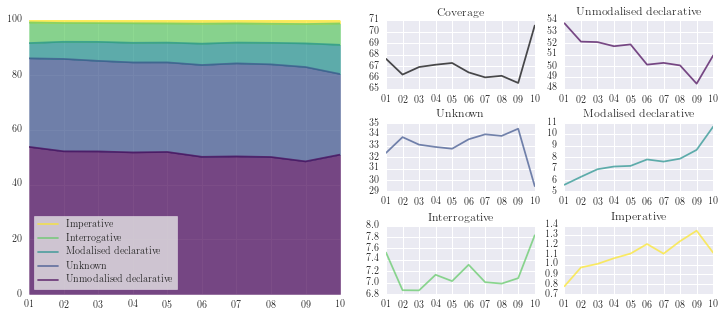

In [8]:
relmoodcounts.results.drop('Coverage', axis=1).multiplot({'kind': 'area', 'alpha': 0.7, 'ylim': (0,100)},
                        {'data': relmoodcounts.results, 'alpha': 0.7, 'kind': 'line'},
                        layout=2).show()

Neat. For now, consult the thesis for talk about the meaning of these changes.

<a name="modalisation"></a>
### Modalisation

We can see already that modalisation, in connection with mood, shifts over time.
First, we can get a list of modals, and modal lemmata, which collapse the
distinguish between *should*, and *shall*, for example.

In [ ]:
modals_w = corpus.interrogate(T, r'MD < __', show=W, save='modals_w')
modals_l = corpus.interrogate(T, r'MD < __', show=L, save='modals_l')

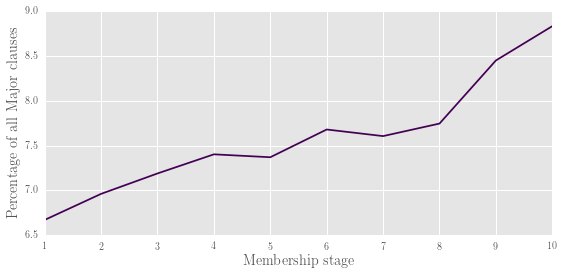

In [57]:
modals_w.totals.index=range(1, 11)
modperc = corpus.modals_w.totals * 100.0 / corpus.features.Clauses
modperc.visualise(kind='line', x_label='Membership stage', y_label='Percentage of all Major clauses').show()

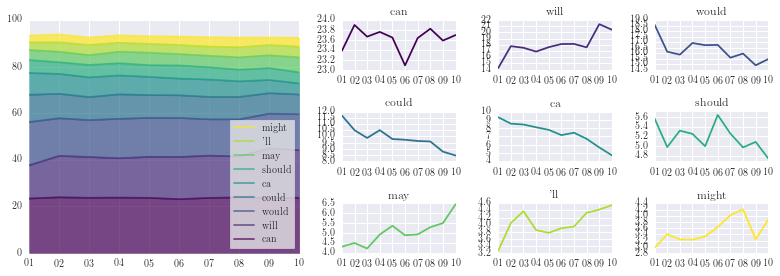

In [20]:
plt = modals_w.rel().multiplot({'alpha': 0.7}, {'kind': 'line'}, layout=5, figsize=(11,4))
plt.tight_layout()
plt.show()

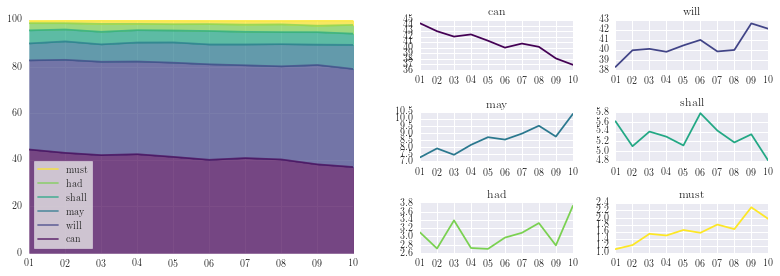

In [24]:
# this lemmatises could > can, would > will, etc.
plt = modals_l.rel().multiplot({'alpha': 0.7}, {'kind': 'line'}, layout=2, figsize=(11,4))
plt.tight_layout()
plt.show()

We can now generate relative frequencies and plot:

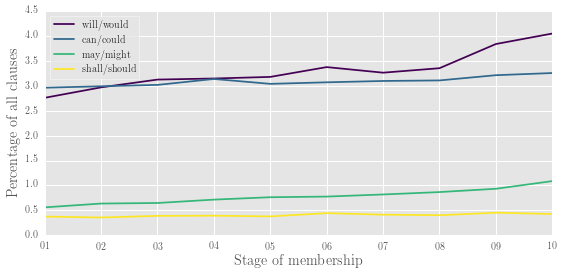

In [27]:
entries_to_merge = {"will/would": r"(^w|\'ll|\'d)",
                    "can/could": r"^c",
                    "may/might": r"^m",
                    "shall/should": r'^sh'}
modals = modals_w.edit(merge_entries = entries_to_merge, just_entries=entries_to_merge.keys())
modals = modals.edit('%', corpus.features.Clauses, sort_by='total')
modals.visualise(x_label='Stage of membership', y_label='Percentage of all clauses', colours='viridis').show()

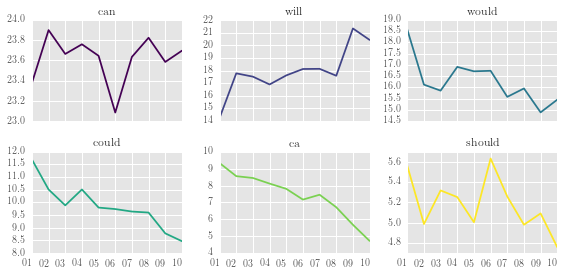

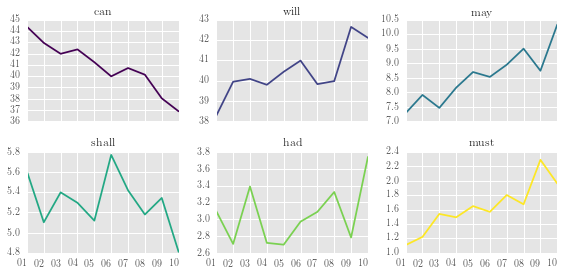

In [13]:
#modw = modals_w.edit()
for datum in [modals_w, modals_l]:
    datum.edit('%', SELF).visualise('Modals in P Corpus',
        subplots=True, layout=(2, 3), colours='viridis').show()

<a name="subject-pronoun-finite-modal-constellations"></a>
#### Subject-pronoun, Finite-modal constellations

In systemic linguistics, the Subjet and Finite play an important role within the
clause, forming the *arguable* part of the proposition. We can look, therefore,
for common constellations of Subject and Finite, without worrying about the
overall Mood.

First, we can collapse on modal lemmata:

In [73]:
# make a list of every pronoun/modal combination
# we'll be making regexes, so we'll use pipe separators
import itertools
modals = [u"would|\'d", 
          u"will|\'ll|wo", 
          u"can|ca", 
          u"could", 
          u"may", 
          u"should", 
          u"might"]

pronouns = [u'i',
            u'you',
            u'we',
            u'he|she|they',
            u'non-pronoun']

combs = list(itertools.product(*[pronouns, modals]))
combs

[(u'i', u"would|'d"),
 (u'i', u"will|'ll|wo"),
 (u'i', u'can|ca'),
 (u'i', u'could'),
 (u'i', u'may'),
 (u'i', u'should'),
 (u'i', u'might'),
 (u'you', u"would|'d"),
 (u'you', u"will|'ll|wo"),
 (u'you', u'can|ca'),
 (u'you', u'could'),
 (u'you', u'may'),
 (u'you', u'should'),
 (u'you', u'might'),
 (u'we', u"would|'d"),
 (u'we', u"will|'ll|wo"),
 (u'we', u'can|ca'),
 (u'we', u'could'),
 (u'we', u'may'),
 (u'we', u'should'),
 (u'we', u'might'),
 (u'he|she|they', u"would|'d"),
 (u'he|she|they', u"will|'ll|wo"),
 (u'he|she|they', u'can|ca'),
 (u'he|she|they', u'could'),
 (u'he|she|they', u'may'),
 (u'he|she|they', u'should'),
 (u'he|she|they', u'might'),
 (u'non-pronoun', u"would|'d"),
 (u'non-pronoun', u"will|'ll|wo"),
 (u'non-pronoun', u'can|ca'),
 (u'non-pronoun', u'could'),
 (u'non-pronoun', u'may'),
 (u'non-pronoun', u'should'),
 (u'non-pronoun', u'might')]

Next, we create *Tregex* queries. This is a query language for bracketed
constitutency trees.

In [74]:
# create tregex queries with these parts
queries = {}
for pro, mod in combs:
    if pro == u'non-pronoun':
        query = r'__ < (VP <<# /(?i)^(%s)$/) < (NP !<<# /PRP/)' % mod
    else:
        query = r'__ < (VP <<# /(?i)^(%s)$/) < (NP <<# (/PRP/ < /(?i)^(%s)$/))' % (mod, pro)
    queries[pro.replace('|', '/') + ' ' + mod.replace('|', '/')] = query
queries

{u'he/she/they can/ca': u'__ < (VP <<# /(?i)^(can|ca)$/) < (NP <<# (/PRP/ < /(?i)^(he|she|they)$/))',
 u'he/she/they could': u'__ < (VP <<# /(?i)^(could)$/) < (NP <<# (/PRP/ < /(?i)^(he|she|they)$/))',
 u'he/she/they may': u'__ < (VP <<# /(?i)^(may)$/) < (NP <<# (/PRP/ < /(?i)^(he|she|they)$/))',
 u'he/she/they might': u'__ < (VP <<# /(?i)^(might)$/) < (NP <<# (/PRP/ < /(?i)^(he|she|they)$/))',
 u'he/she/they should': u'__ < (VP <<# /(?i)^(should)$/) < (NP <<# (/PRP/ < /(?i)^(he|she|they)$/))',
 u"he/she/they will/'ll/wo": u"__ < (VP <<# /(?i)^(will|'ll|wo)$/) < (NP <<# (/PRP/ < /(?i)^(he|she|they)$/))",
 u"he/she/they would/'d": u"__ < (VP <<# /(?i)^(would|'d)$/) < (NP <<# (/PRP/ < /(?i)^(he|she|they)$/))",
 u'i can/ca': u'__ < (VP <<# /(?i)^(can|ca)$/) < (NP <<# (/PRP/ < /(?i)^(i)$/))',
 u'i could': u'__ < (VP <<# /(?i)^(could)$/) < (NP <<# (/PRP/ < /(?i)^(i)$/))',
 u'i may': u'__ < (VP <<# /(?i)^(may)$/) < (NP <<# (/PRP/ < /(?i)^(i)$/))',
 u'i might': u'__ < (VP <<# /(?i)^(might)$/)

We can now pass these queries into the `interrogate()` method, counting the
number of occurrences.

In [21]:
modal_configs = corpus.interrogate(T, queries, show = C)
modal_configs.results

,he/she/they can/ca,he/she/they could,he/she/they may,he/she/they might,he/she/they should,he/she/they will/'ll/wo,he/she/they would/'d,i can/ca,i could,i may,i might,i should,i will/'ll/wo,i would/'d,we can/ca,we could,we may,we might,we should,we will/'ll/wo,we would/'d,you can/ca,you could,you may,you might,you should,you will/'ll/wo,you would/'d
01,430,188,92,42,67,555,441,2735,1003,162,152,348,1059,1731,109,33,2,0,30,64,61,610,106,117,70,149,252,103
02,414,176,78,59,61,460,334,2010,652,92,100,244,1078,1120,131,30,7,5,20,93,50,587,93,97,72,116,271,101
03,383,152,68,52,82,515,393,2070,710,85,80,247,1146,1237,129,30,7,7,16,135,43,586,83,91,86,142,290,89
04,427,183,92,53,79,528,390,2006,687,91,82,235,1072,1289,171,45,16,11,18,132,53,816,138,126,100,187,335,126
05,382,136,105,46,66,510,360,1879,673,89,80,221,1020,1256,209,48,8,7,20,107,47,794,103,128,108,193,391,136
06,355,167,83,60,81,494,333,1778,646,74,92,231,1093,1310,207,35,9,5,26,120,71,836,151,150,107,204,471,161
07,361,153,98,59,77,490,324,1662,555,79,75,174,1010,1226,165,41,15,5,23,139,59,977,164,144,130,213,485,143
08,400,169,95,65,76,446,370,1716,657,68,91,192,1077,1322,214,48,19,8,38,135,62,983,175,174,169,214,513,163
09,347,151,92,27,61,513,307,1355,491,55,68,162,856,1136,229,47,11,4,26,122,66,1087,195,208,151,259,763,180
10,385,194,145,45,86,485,327,1119,395,66,34,127,707,1343,167,57,13,6,19,170,73,1328,266,275,261,248,788,195


Let's get these as a percentage of all clauses, and sort the results by their
trajectory over the course of membership:

In [22]:
inc_con = modal_configs.edit('%', corpus.features.Clauses, sort_by = 'increase')
dec_con = modal_configs.edit('%', corpus.features.Clauses, sort_by = 'decrease')

Now, we can visualise our results. Let's start with those constellations that
are increasing in frequency.


15:00:17: images/subj-fin-const-p.png created.


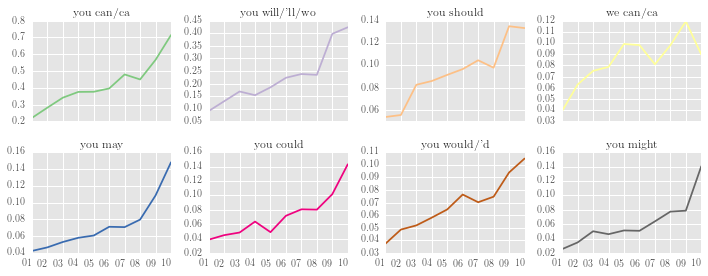

In [23]:
# get top 8, sort by total and plot
dat = inc_con.results.iloc[:,:8].edit(sort_by='total')
dat.visualise(x_label='Subcorpus', save='subj-fin-const-p', subplots=True, 
              layout=(2, 4), # y_label='Percentage of all clauses'
              y_label=False, figsize=(10,4)).show()

Now, let's try those that are decreasing.


15:00:46: images/subj-fin-const-p-dec.png created.


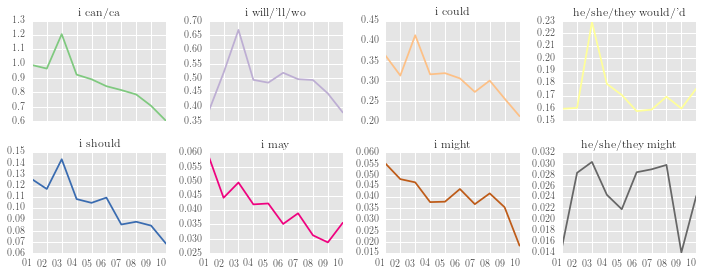

In [24]:
dat = dec_con.results.iloc[:,:8].edit(sort_by='total')
dat.visualise(x_label='Subcorpus', save='subj-fin-const-p-dec', subplots=True,
              layout=(2, 4), # y_label='Percentage of all clauses'
              y_label=False, figsize=(10, 4)).show()

Let's hand pick some interesting examples:


15:01:01: images/subj-fin-const-p-page.png created.


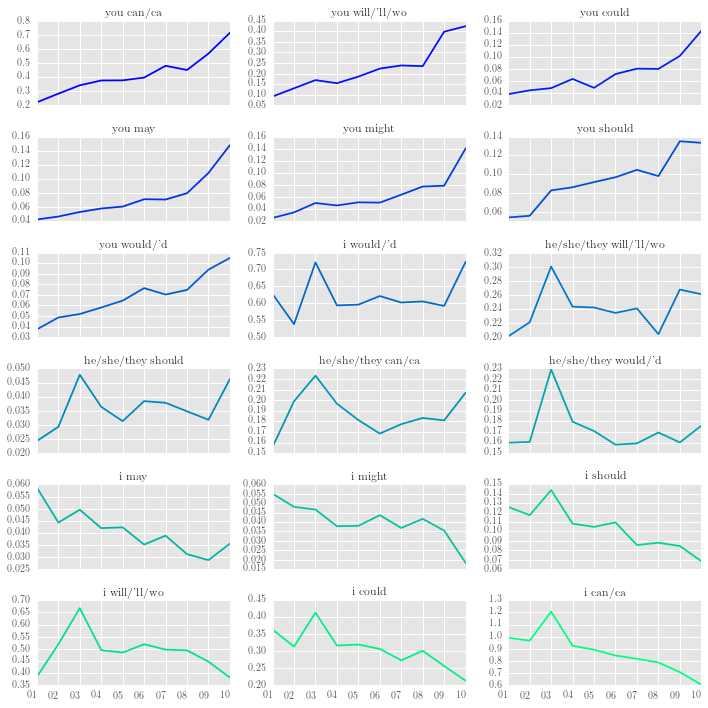

In [25]:
interesting = [u'i can/ca',
               u"i will/'ll/wo",
               u'i should',
               u'i could',
               u'i might',
               u'i may',
               u"i would/'d",
               u'you can/ca',
               u"you will/'ll/wo",
               u'you should',
               u'you may',
               u"he/she/they would/'d",
               u"he/she/they should",
               u"he/she/they can/ca",
               u"he/she/they will/'ll/wo",
               u'you could',
               u"you would/'d",
               u'you might']

dat = modal_configs.edit('%', corpus.features.Clauses, 
                    just_entries=interesting, sort_by='increase', keep_stats=True)
dat.visualise(x_label='Subcorpus', save='subj-fin-const-p-page', subplots=True, 
    layout=(6, 3), num_to_plot='all',
    y_label=False, figsize=(10,10), colours='winter').show()

To concordance one, we can use the `concordance()` method. This takes the same
kinds of arguments as `interrogate()`. We can restrict our focus to the first
subcorpus of the P Corpus using indexing:

In [ ]:
conc = corpus[0].concordance(T, queries['i can/ca'], show=W)

In [45]:
conc[[L, M, R]]

,l,m,r
0,my life has n't been the best but i 've coped with it the best,i can,while also learning to battle this illness .
1,but it seems to me that,i can relate,.
2,i literally have to peel myself out of bed in the morning and all,i can think about all day,is sleeping .
3,,i can not stop crying .,
4,,i can barely stay awake .,
5,"i feel so fat and disgusting , but",i ca n't stop eating,.
6,it makes me sooo upset because i know my true potential and i feel like there 's nothing,i can do about it,.
7,i literally just keep thinking about how,i can go back to the psych ward,", just so i can get out of everyday life for a while ."
8,"i literally just keep thinking about how i can go back to the psych ward , just so",i can get out of everyday life for a while,.
9,,"i can not get along with any of my coworkers , as well as people at home .",


We can also look at differences in Polarity:

In [ ]:
pos = r'__ < (VP !> VP < (MD < /(?i)^({})$/) ( !< (RB < /(?i)^n.t$/) & !< (ADVP <<# ' \
       '/(?i)(never|rarely|seldom)/))) < (NP <<# (/PRP/ < /(?i)^({})$/))'
neg = r'__ < (VP !> VP < (MD < /(?i)^({})$/) ( < (RB < /(?i)^n.t$/) | < (ADVP <<# ' \
       '/(?i)(never|rarely|seldom)/))) < (NP <<# (/PRP/ < /(?i)^({})$/))'

    data = {}

mdict = {'would': r'would|\'d|will|\'ll|wo"',
         'could': 'can|could',
         'should': 'shall|should',
         'might': 'might|must|may'}

for d, crit in mdict.items():
    q = {'I {}'.format(d): pos.format(crit, 'i'),
         'I {} not'.format(d): neg.format(crit, 'i'),
         'You {}'.format(d): pos.format(crit, 'you'),
         'You {} not'.format(d): neg.format(crit, 'you')}

    res = corpus.interrogate(T, q, show=C, multiprocess=4)
    data[d] = res

from corpkit.interrogation import Interrodict
subjmodpol = Interrodict(data)

In [1]:
from corpkit import *
import os
os.chdir('../new_thesis')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

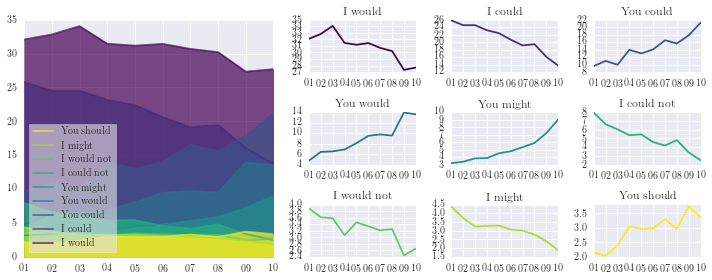

In [30]:
%matplotlib inline
subjmodpol = load('subjmodpol')
#subjmodpol = load('../new_thesis/saved_interrogations/subjmodpol')

dat = subjmodpol.collapse('k').edit('%', SELF, denominator_totals=True)
d = dat.results.multiplot({'kind': 'area',
                           'stacked': False, 'num_to_plot': 9,
                           'legend_pos': 'lower left', 'legend_alpha': 0.6, 'alpha': 0.7},
                          {'kind': 'line', 'pie_legend': False},
                          layout=5, figsize=(10, 4))
#dat.visualise(colours='viridis', kind='area', ylim=(0, 100), legend_alpha=True, legend_pos = 'lower left')
d.tight_layout()
d.show()

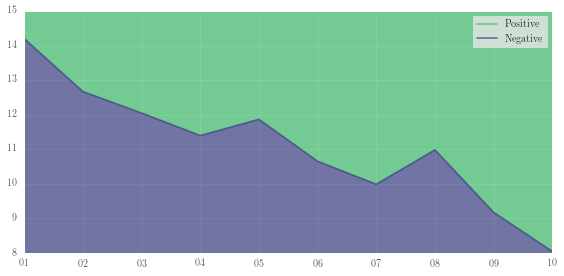

In [82]:
collap = subjmodpol.collapse('k')
posneg = collap.edit('%', SELF, merge_entries={'Negative': 'not', 'Positive': r'^(I|Y)'})
posneg.visualise(kind='area', alpha=0.7, colours=cmap).show()

We can look at whether modality + polarity is at risk:

In [ ]:
modpol = {'Modalised, positive': r'VP < MD ( !< (RB < /(?i)^n.t$/) & !< (ADVP <<# /(?i)(never|rarely|seldom)/))',
          'Modalised, negative': r'VP < MD ( < (RB < /(?i)^n.t$/) | < (ADVP <<# /(?i)(never|rarely|seldom)/))',
          'Unmodalised, positive': r'VP !< MD ( !< (RB < /(?i)^n.t$/) & !< (ADVP <<# /(?i)(never|rarely|seldom)/))',
          'Unmodalised, negative': r'VP !< MD ( < (RB < /(?i)^n.t$/) | < (ADVP <<# /(?i)(never|rarely|seldom)/))'}

mp = corpus.interrogate(T, modpol, show=C, multiprocess=4, save='mod-pol')

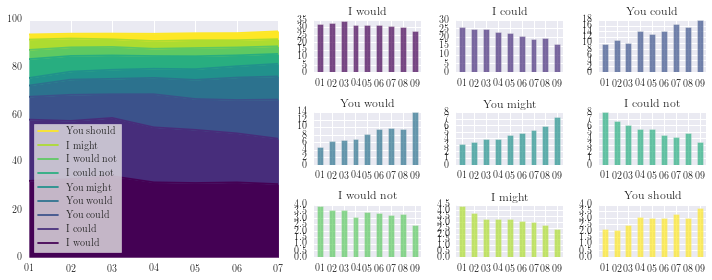

In [25]:
import seaborn as sns
from corpkit.other import load
%matplotlib inline
data = load('../new_thesis/saved_interrogations/subjmodpol')
data = data.collapse('k')
df1 = data.rel().results.T.iloc[:9,:9]

x = df1.multiplot({'kind': 'area'}, {'kind': 'bar', 'alpha': 0.7}, layout=5)
x.tight_layout()
x.show()

In [68]:
#f, (a, b) = plt.subplots(1, 2)
mp.rel().visualise(kind='area', alpha=0.7, colours='viridis', ylim=(85,100), ax=a)
#s = mp.rel().visualise(subplots=True,layout=(2,2), alpha=0.7, colours='viridis').show()

Maybe it's pronoun + polarity:

In [ ]:
propol = {'Pronoun, positive': r'__ < (NP <<# /PRP.?/) < (VP ( !< (RB < /(?i)^n.t$/) & !< (ADVP <<# /(?i)(never|rarely|seldom)/)))',
          'Pronoun, negative': r'__ < (NP <<# /PRP.?/) < (VP ( < (RB < /(?i)^n.t$/) | < (ADVP <<# /(?i)(never|rarely|seldom)/)))',
          'Non-pronoun, positive': r'__ < (NP !<<# /PRP.?/) < (VP ( !< (RB < /(?i)^n.t$/) & !< (ADVP <<# /(?i)(never|rarely|seldom)/)))',
          'Non-pronoun, negative': r'__ < (NP !<<# /PRP.?/) < (VP ( < (RB < /(?i)^n.t$/) | < (ADVP <<# /(?i)(never|rarely|seldom)/)))'}

sp = corpus.interrogate(T, propol, show=C, multiprocess=4,save='subj-pol')

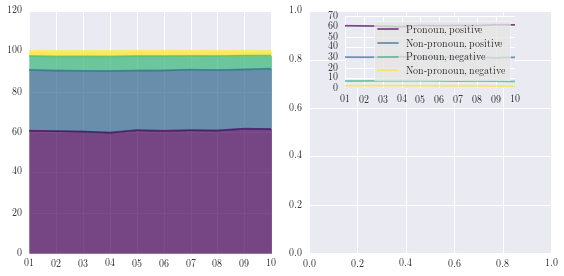

In [128]:
#sp = load('P-parsed-subj-pol')
sp.rel().visualise(kind='area', alpha=0.7, colours='viridis', ax=ax1)
p = sp.rel().visualise(kind='line',alpha=0.7, colours='viridis', ax=inset_axes)
plt.show()


We can also collapse along the dimension of tense, rather than by lemma form:

In [53]:
# generate subject TENSE
import itertools
tenses = [r"( <<# /VB[ND]$/ | <<# (MD < /(?i)could|would|should|might|'d/) )",
          r"( <<# /VB([^ND]$|$)/ | <<# (MD < /(?i)will|can|may|shall|'ll|ca|wo'/) )"]

pronouns = [u'i',
            u'you',
            u'we',
            u'he|she|they']

combs = list(itertools.product(*[pronouns, tenses]))
queries = {}
for pro, ten in combs:
    if 'would' in ten:
        tense = 'PAST'
    else:
        tense = 'PRESENT'
    query = r'__ %s < (NP <<# /(?i)^(%s)$/)' % (ten, pro)
    queries[pro.replace('|', '/') + ' ' + tense] = query
queries

{u'he/she/they PAST': u"__ ( <<# /VB[ND]$/ | <<# (MD < /(?i)could|would|should|might|'d/) ) < (NP <<# /(?i)^(he|she|they)$/)",
 u'he/she/they PRESENT': u"__ ( <<# /VB([^ND]$|$)/ | <<# (MD < /(?i)will|can|may|shall|'ll|ca|wo'/) ) < (NP <<# /(?i)^(he|she|they)$/)",
 u'i PAST': u"__ ( <<# /VB[ND]$/ | <<# (MD < /(?i)could|would|should|might|'d/) ) < (NP <<# /(?i)^(i)$/)",
 u'i PRESENT': u"__ ( <<# /VB([^ND]$|$)/ | <<# (MD < /(?i)will|can|may|shall|'ll|ca|wo'/) ) < (NP <<# /(?i)^(i)$/)",
 u'we PAST': u"__ ( <<# /VB[ND]$/ | <<# (MD < /(?i)could|would|should|might|'d/) ) < (NP <<# /(?i)^(we)$/)",
 u'we PRESENT': u"__ ( <<# /VB([^ND]$|$)/ | <<# (MD < /(?i)will|can|may|shall|'ll|ca|wo'/) ) < (NP <<# /(?i)^(we)$/)",
 u'you PAST': u"__ ( <<# /VB[ND]$/ | <<# (MD < /(?i)could|would|should|might|'d/) ) < (NP <<# /(?i)^(you)$/)",
 u'you PRESENT': u"__ ( <<# /VB([^ND]$|$)/ | <<# (MD < /(?i)will|can|may|shall|'ll|ca|wo'/) ) < (NP <<# /(?i)^(you)$/)"}

In [55]:
#pronountense = corpus.interrogate(T, queries, show = C, multiprocess = 2)
pronountense.save('protense')


16:18:59: Data saved: saved_interrogations/P-parsed-protense.p



Like with Subject-Modal constellations, we then calculate each as a percentage
of all clauses, and plot:


16:19:11: images/subj-ten-const-p.png created.


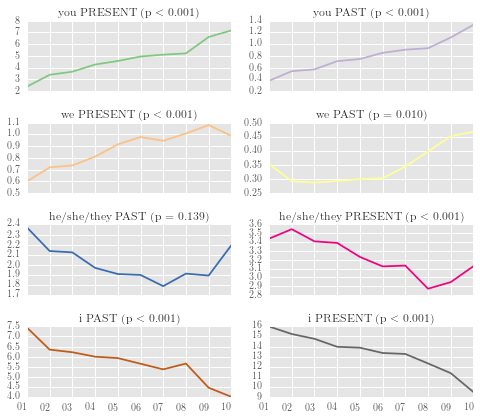

In [56]:
q = pronountense.edit('%', corpus.features['Clauses'], sort_by='increase', keep_stats=True)
q.visualise(subplots=True, num_to_plot=8, layout=(4, 2), show_p_val=True, 
            y_label=False, figsize=(7, 6), save='subj-ten-const-p').show()

From the above, it seems that TENSE doesn't really change over time. PERSON, on
the other hand, might. To get just PERSON data, we can use the `replace_names`
`edit()` argument, which will delete a regular expression from every column
name, or do substitutions if a dict of `{newname: regex}` is passed in.


12:10:38: images/prosubj-p.png created.


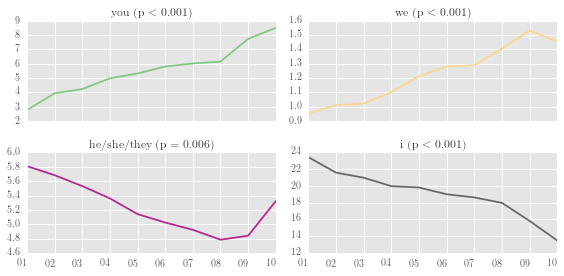

In [57]:
m = pronountense.edit('%', corpus.features['Clauses'], replace_names =r' (PRESENT|PAST)', 
                                 sort_by='increase', keep_stats=True)
m.visualise(subplots=True, layout=(2,2), show_p_val=True, save='prosubj-p').show()

For the sake of completeness, we can also look at tense, disregarding modalised clauses:

In [ ]:
q = {'Past': r'__ < NP < (VP <<# /VB[ND]/)',
     'Present': r'__ < NP < (VP !<<# /VB[ND]/)'}
tense_nomodal = corpus.interrogate(T, q, show=C)


15:34:17: images/tense-area.png created.


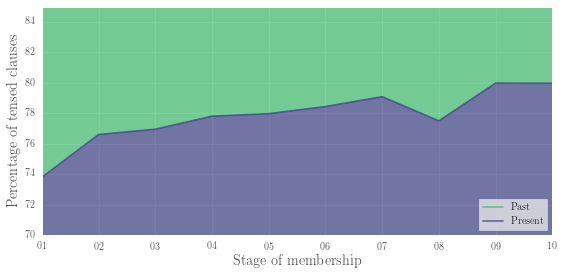

In [61]:
dat = tense_nomodal.edit('%', SELF)
dat.visualise(kind='area', alpha=0.7, colours=cmap, x_label='Stage of membership', save='tense-area',
              y_label='Percentage of tensed clauses', legend_pos='lower right', ylim=(70,85)).show()

<a name="advice"></a>
### Advice

One thing that varies quite a lot in frequency is the *I would* mood block. In
the thesis, these constructions are manually counted by function. Because there
are too many examples to code by hand, we restrict the search to the first and
last subcorpus, and to clauses with an adverbial modifier of the VP.

Here's a query to get such clauses:

In [59]:
iwould = r'__ < (VP <<# /(?i)^would$/ << RB) < (NP <<# /(?i)^I$/)'

and here's how to get examples from new and veteran users' posts:

In [60]:
new = corpus[0].concordance(T, iwould, show=W)
new[[L, M, R]]


12:19:41: Interrogating and concordancing 01 ...
          Searching parse trees
          Query:   t: __ < (VP <<# /(?i)^would$/ << RB) < (NP <<# /(?i)^I$/)
          Interrogating and concordancing corpus ... 



12:20:21: Concordancing finished! 785 results.


,l,m,r
0,,"like , sometimes i would be so mellow and quiet , sexually despondent and just want to sit with ...",
1,"however , i know if i had n't been a danger to myself",i would still be waiting now for a formal diagnosis and for the proper treatment,.
2,if i were going to adopt a baby and found out it had a bipolar father,i would n't care if i felt it was the right thing to do,.
3,i have been through many different trials with my brother especially being bipolar but,i would n't trade him for nothing in the world,.
4,"my doctor -lrb- who comes highly reccomened -rrb- says give the meds time to run their course , but",i would think six months is long enough,", but then again i do n't really know as i was only diagnosed a little over a year ago after a s..."
5,,i would n't so much say that it causes me to lose weight,", but rather it helps control my compulsion to overeat ."
6,i would like to say that i see it as `` bipolar affective condition '' not `` bipolar affective ...,"i am , i would not have my attention to detail or other aspects of my personality that make me u...",.
7,"it 's good to know i am not alone , though",i would never wish this on anyone,.
8,,"i would lash out with all intent to hurt verbally , physically and mentally",and then after a week of aggressive behaviours i am normal and do n't remember the angry part ti...
9,it is punishment in our world for crimes we never comitted and it sucks but one common factor we...,i would suggest using that to research for truth and facts and build a diverse knowledge which o...,", a sort of shield if you like , i also find writting my thoughts on subjects of interest down r..."


In [61]:
vet = corpus[9].concordance(T, iwould, show=W)
vet[[L, M, R]]


12:20:22: Interrogating and concordancing 10 ...
          Searching parse trees
          Query:   t: __ < (VP <<# /(?i)^would$/ << RB) < (NP <<# /(?i)^I$/)
          Interrogating and concordancing corpus ... 



12:20:55: Concordancing finished! 556 results.


,l,m,r
0,the family to family is a very good program and,i would highly recommend it,.
1,,"i would encourage you to read as many books as you can , learn all about the various medications...",
2,,"i would definitely mention this to his pdoc , perhaps call his office and see if you should brin...",
3,,"take care , tsohl kat , i would let your pdoc know that you 're still continuing to rapid cycle .",
4,"that being said ,",i would n't just go and quit,... perhaps it is time to look for a less stressful job and once you find it entertain a change ...
5,,"if not , i would highly recommend it .",
6,"wow ... green , 27 years is alot and",i would hate to see you lose the perks please do n't go making a decision like this too quickly ...,.
7,"wow ... green , 27 years is alot and i would hate to see you lose the perks please do n't go mak...",i would ask somebody you really,trust before doing so .
8,,"tsohl kat , i would definitely talk to your pdoc on monday about the clonazepam .",
9,as each reached the age of going to parties,"i would pull them aside , give them a little card with some free long distance minutes on it and...",", and i would tell them , `` this is a card for you ."


Here are the results of the categorisation:

In [46]:
results = ",Past behaviour,Advice,Request,\\noindent Inclination & \\\ hypothetical, Hedged salutation,\\noindent Past sense \\\ of will\n"\
          "New members,76,22,66,93,5,22\n"\
          "Veteran members,9,69,5,58,0,7"
from StringIO import StringIO
wouldcat = pd.read_csv(StringIO(results),index_col=0)
wouldcat

,Past behaviour,Advice,Request,\noindent Inclination & \\ hypothetical,Hedged salutation,\noindent Past sense \\ of will
New members,76,22,66,93,5,22
Veteran members,9,69,5,58,0,7


This can now be plotted:


21:17:57: images/iwould-vid.png created.


<module 'matplotlib.pyplot' from '/Users/daniel/virtenvs/ssled/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

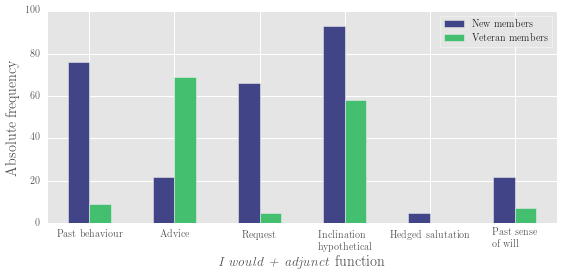

In [49]:
import matplotlib.pyplot as plt
wouldcat.visualise(kind='bar', y_label='Absolute frequency', 
                   x_label=r'\emph{I would + adjunct} function', transpose=True, rot=False,
                   colours=cmap, save='iwould-vid')